In [ ]:
%%capture
!pip install transformers datasets speechbrain
# !git clone https://github.com/gabrielmittag/NISQA.git
# %cd NISQA
# !pip install -r requirements.txt
# !wget -P models/ https://github.com/gabrielmittag/NISQA/releases/download/v1.0/nisqa_tts.ckpt


# Text to speech

## Load the dataset

In [ ]:
from datasets import load_dataset, Audio, Dataset

dataset = load_dataset("facebook/voxpopuli", "en", split="train", streaming = True,trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

voxpopuli.py:   0%|          | 0.00/8.84k [00:00<?, ?B/s]

In [ ]:
type(dataset)

datasets.iterable_dataset.IterableDataset

In [ ]:

# Convert the streaming dataset to a list with 10k samples
data_list = []
for i, example in enumerate(dataset):
    if i >= 1000:
        break
    data_list.append(example)

# Convert the list back to a Dataset object
dataset = Dataset.from_list(data_list)

# Verify the dataset type and length
print(type(dataset))
print(len(dataset))

<class 'datasets.arrow_dataset.Dataset'>
1000


In [ ]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

## Preprocess the data

Let's begin by defining the model checkpoint to use and loading the appropriate processor:

In [ ]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

### Text cleanup for SpeechT5 tokenization

In [ ]:
tokenizer = processor.tokenizer

In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
dataset_vocab - tokenizer_vocab

{' '}

Spaces are already replaced by `▁` in the tokenizer and don't need to be handled separately.

Now that you have dealt with special characters in the text, it's time to shift focus to the audio data.

### Speakers

In [ ]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

By plotting a histogram you can get a sense of how much data there is for each speaker.

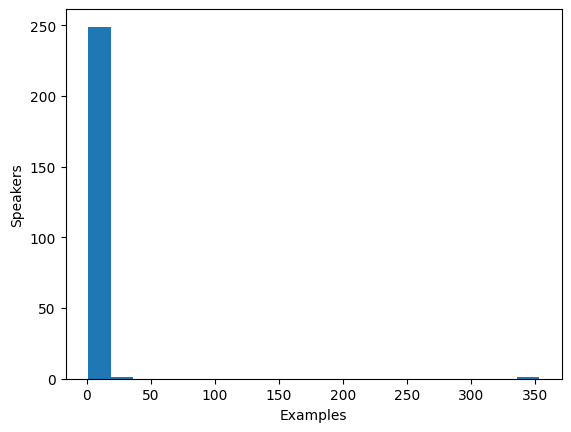

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

Let's check how many speakers remain:

In [ ]:
len(set(dataset["speaker_id"]))

251

Let's see how many examples are left:

In [ ]:
len(dataset)

1000

### Speaker embeddings

In [ ]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

<ipython-input-14-f28baad2ea60>:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

### Processing the dataset

In [ ]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Verify the processing is correct by looking at a single example:

In [ ]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

Speaker embeddings should be a 512-element vector:

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

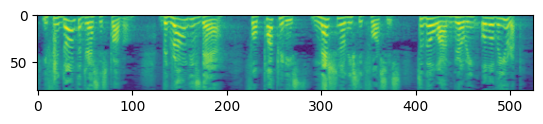

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [ ]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

743

Next, create a basic train/test split:

In [ ]:
# Step 1: Split the dataset into train+val (90%) and test (10%)
train_val_dataset = dataset.train_test_split(test_size=0.1)

# Step 2: Split train+val into train (80%) and val (10% of total)
train_val_split = train_val_dataset['train'].train_test_split(test_size=0.1111)  # Ensures ~10% of total

# Final Step: Reassign the splits to the `dataset` variable
dataset = {
    'train': train_val_split['train'],
    'val': train_val_split['test'],
    'test': train_val_dataset['test']
}

dataset

{'train': Dataset({
     features: ['input_ids', 'labels', 'speaker_embeddings'],
     num_rows: 593
 }),
 'val': Dataset({
     features: ['input_ids', 'labels', 'speaker_embeddings'],
     num_rows: 75
 }),
 'test': Dataset({
     features: ['input_ids', 'labels', 'speaker_embeddings'],
     num_rows: 75
 })}

### Data collator

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(input_ids=input_ids, labels=label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100)

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([len(feature["input_values"]) for feature in label_features])
            target_lengths = target_lengths.new(
                [length - length % model.config.reduction_factor for length in target_lengths]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

## Train the model

Load the pre-trained model from the same checkpoint as you used for loading the processor:

In [ ]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training.

In [ ]:
model.config.use_cache = False

In [ ]:
dataset

{'train': Dataset({
     features: ['input_ids', 'labels', 'speaker_embeddings'],
     num_rows: 593
 }),
 'val': Dataset({
     features: ['input_ids', 'labels', 'speaker_embeddings'],
     num_rows: 75
 }),
 'test': Dataset({
     features: ['input_ids', 'labels', 'speaker_embeddings'],
     num_rows: 75
 })}

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Updated training configuration for epochs
training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_en",  # Output directory
    per_device_train_batch_size=8,  # Increased batch size for better throughput
    gradient_accumulation_steps=4,  # Adjust gradient accumulation for better memory management
    learning_rate=1e-5,  # Low learning rate for fine-tuning
    warmup_steps=500,  # Set warmup steps
    num_train_epochs=3,  # Number of epochs for training
    gradient_checkpointing=False,  # Disable gradient checkpointing for faster training (optional)
    fp16=True,  # Use mixed precision for faster training
    eval_strategy="epoch",  # Evaluate model at the end of each epoch
    save_strategy="epoch",  # Save model at the end of each epoch
    logging_strategy="epoch",  # Log at the end of each epoch
    per_device_eval_batch_size=4,  # Increase batch size for evaluation
    report_to=["tensorboard"],  # Log to TensorBoard for monitoring
    load_best_model_at_end=True,  # Load the best model at the end of training
    greater_is_better=False,  # Set evaluation metric to use for model selection
    label_names=["labels"],  # Label names for training
    push_to_hub=False,  # Skip pushing to HuggingFace Hub
    dataloader_num_workers=4,  # Increase the number of workers for faster data loading
    dataloader_pin_memory=True,  # Pin memory for faster data transfer to GPU
)

# Ensure the model is on the correct device
model.to(device)

# Create the Trainer
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    data_collator=data_collator,
    processing_class=processor,  # tokenizer
)

# Now you can start training
trainer.train()


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,3.251600,0.676817
1,3.017700,0.664700
2,3.014100,0.652041


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is 

TrainOutput(global_step=54, training_loss=3.0944642667417175, metrics={'train_runtime': 139.5809, 'train_samples_per_second': 12.745, 'train_steps_per_second': 0.387, 'total_flos': 266133356945280.0, 'train_loss': 3.0944642667417175, 'epoch': 2.96})

In [ ]:
# Evaluate on the test dataset
test_results = trainer.evaluate(eval_dataset=dataset["test"])
print(test_results)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 0.6450127959251404, 'eval_runtime': 2.9057, 'eval_samples_per_second': 25.811, 'eval_steps_per_second': 6.539, 'epoch': 2.96}


In [ ]:
# Save the fine-tuned model
save_path = "Speecht5_finetuned_voxpopuli_en_saved"
trainer.save_model(save_path)

# Print the exact path where the model is saved
print(f"Model saved to: {save_path}")


Model saved to: Speecht5_finetuned_voxpopuli_en_saved


## Inference

In [ ]:
model = SpeechT5ForTextToSpeech.from_pretrained("Speecht5_finetuned_voxpopuli_en_saved")

Pick an example, here we'll take one from the test dataset. Obtain a speaker embedding.

In [ ]:
example = dataset["test"][3]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [ ]:
# Save to file
torch.save(speaker_embeddings, "speaker_embeddings.pt")
print("Speaker embeddings saved to 'speaker_embeddings.pt'")

Speaker embeddings saved to 'speaker_embeddings.pt'


Define some input text and tokenize it.

In [ ]:
text = "Hello my name is steve and today we are having"

Preprocess the input text:

In [ ]:
inputs = processor(text=text, return_tensors="pt")

Create a spectrogram with your model:

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

Visualize the spectrogram, if you'd like to:

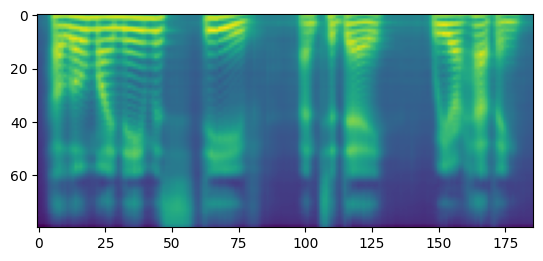

In [ ]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

In [ ]:
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [ ]:
from IPython.display import Audio

Audio(speech.numpy(), rate=16000)

# Application

In [ ]:
%%capture
!pip install streamlit pyngrok

In [ ]:
%%writefile app.py
import torch
import numpy as np
import streamlit as st
from transformers import SpeechT5ForTextToSpeech, SpeechT5Processor, SpeechT5HifiGan
from tempfile import NamedTemporaryFile
import os
import scipy.io.wavfile as wav

# Initialize the processor (shared for both models)
processor = None

# Lazy loading of models
def load_processor():
    global processor
    if processor is None:
        processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

def load_baseline_model():
    return SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

def load_finetuned_model():
    return SpeechT5ForTextToSpeech.from_pretrained("/content/Speecht5_finetuned_voxpopuli_en_saved")

def load_vocoder():
    return SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

# Load speaker embeddings from the local path
def load_speaker_embeddings():
    speaker_embeddings_path = "/content/speaker_embeddings.pt"
    if not os.path.exists(speaker_embeddings_path):
        raise FileNotFoundError(f"Speaker embeddings not found at {speaker_embeddings_path}")
    embeddings = torch.load(speaker_embeddings_path)
    # Make sure embeddings have correct shape (add a batch dimension if needed)
    if len(embeddings.shape) == 1:
        embeddings = embeddings.unsqueeze(0)
    return embeddings

# Streamlit UI
st.title("SpeechT5 Text-to-Speech")
st.write("Generate speech from text using baseline or fine-tuned model.")

# Input text from the user
text_input = st.text_area("Enter the text to convert to speech", "Hello, world!")

# Model type selection (Baseline or Fine-tuned)
model_type = st.radio("Select the model", ["baseline", "finetuned"])

# Generate speech button
if st.button("Generate Speech"):
    try:
        # Load required resources on demand
        load_processor()
        speaker_embeddings = load_speaker_embeddings()
        vocoder = load_vocoder()

        # Select the model based on user input
        if model_type == "finetuned":
            model = load_finetuned_model()
        elif model_type == "baseline":
            model = load_baseline_model()

        # Process input text
        inputs = processor(text=text_input, return_tensors="pt")

        # Generate speech (spectrogram to waveform)
        speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

        # Convert the speech tensor to numpy array and ensure it's in the correct format (float32)
        speech_numpy = speech.squeeze().cpu().numpy()

        # Assuming the model's sample rate is 22050 Hz (adjust as needed)
        sample_rate = 22050

        # Save the speech to a temporary .wav file
        with NamedTemporaryFile(delete=False, suffix=".wav") as temp_audio:
            # The wav file expects an integer sample rate and data in 16-bit PCM format
            wav.write(temp_audio.name, sample_rate, (speech_numpy * 32767).astype(np.int16))  # Convert to 16-bit PCM

        # Play audio in the app
        st.audio(temp_audio.name, format="audio/wav")
    except Exception as e:
        st.error(f"Error: {e}")


Writing app.py


In [ ]:
!pkill ngrok

In [ ]:

# Set up ngrok tunnel and run the Streamlit app
from pyngrok import ngrok
import os

# Authenticate with your ngrok authtoken (replace with your own if needed)
ngrok.set_auth_token("2qe660ETbU1aCf9nYaweYL6zVR7_GqGRja7q9X8ZwGpiEbig")

# Open an ngrok tunnel to the Streamlit app running on port 8501
public_url = ngrok.connect(8501)

# Print the URL where the app is accessible
print(f"Streamlit app is live at {public_url}")

# Run the Streamlit app in the background
os.system("streamlit run app.py &")

# Print the website URL explicitly
print("Visit the following URL to view the Streamlit app:")
print(public_url)


Streamlit app is live at NgrokTunnel: "https://db26-35-197-140-218.ngrok-free.app" -> "http://localhost:8501"
Visit the following URL to view the Streamlit app:
NgrokTunnel: "https://db26-35-197-140-218.ngrok-free.app" -> "http://localhost:8501"
